In [ ]:
#WORD2VEC SKIP-GRAM NEGATIVE SAMPLING REAL  WORLD EXAMPLE

In [113]:
#Make a sighle list of collections of strigs of partial sentences
#dependencies
import numpy as np
import random
import csv
import re
path = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\World_Order_by_Henry_Kissinger.csv'

#read the book
def read_book(path):
    f = open(path, encoding="utf8")
    csv_f = csv.reader(f)

    book = []
    for row in csv_f:
        book.append(row[0])
    
    return book

#processing get desired corpus, finding uniq set of words
def preprocess(book):
    
    #join the string into a long single string
    whole_book=' '.join(book)

    #lower case and remove all the symbols
    #then remove the digits
    words_no_dig_punc = (re.sub(r'[^\w]', ' ', whole_book.lower())).split()
    words_no_dig_punc = [x for x in words_no_dig_punc if not any(c.isdigit() for c in x)]

    #finding unique words
    #Count and find most common words
    from collections import Counter
    word_counts = Counter(words_no_dig_punc)
    word_counts = word_counts.most_common()   #A sorted version

    #Top 20 most common are selected --> add and subtract few words to it as deemed appropriate
    stop_words = [item[0] for item in (word_counts[:20])]
    not_stop = ['world', 'order', 'war', 'not']
    stop_words = [e for e in stop_words if e not in (not_stop)]
    stop_words.append('chapter')
    
    #Make a corpus without these stop words
    vocab = list(filter(lambda x: x not in stop_words, words_no_dig_punc))
    
    #From corpus get all uniq words --> to be indexed and tokenized (to one hot vectors)
    uniq_words = list(set(vocab))
    
    words_to_ints ={k: v for v, k in enumerate(uniq_words)}  #Redundant, Not using it
    ints_to_words ={v: k for v, k in enumerate(uniq_words)}  #Redundant, Not using it

    #To tokenize all the words in corpus the indices of words in uniq_words work as look up table
    vocab_int_pair= []
    for i in range(len(vocab)):
        vocab_int_pair.append([vocab[i], uniq_words.index(vocab[i])])

    #Finally just take the tokenized version of corpus to be loaded into network to train    
    int_arr_of_vocab = np.array(vocab_int_pair)[:, 1].astype(np.int)
    
    return (whole_book, vocab, uniq_words, words_to_ints,  vocab_int_pair, ints_to_words, int_arr_of_vocab)


In [115]:
book = read_book(path)
whole_book, vocab, uniq_words, words_to_ints,  vocab_int_pair, ints_to_words, int_arr_of_vocab =preprocess(book[:100]) 

In [116]:
len(uniq_words), len(vocab)

(303, 437)

In [161]:
###############################################################################################
#Generating pairs of  true samples -->co-occuring within a given frame of window size, labeling the pair 1
#int_arr_of_vocab --> Tokenized corpus
#window --> Selected window
#True pairs start at index +w and ends at index -w (length - w), as only these have full complement of pairs
#Much easier to code this way than accomodating all elements for all window sizes

def gen_true(int_arr_of_vocab, window):
    
    true_list = []
    
    #temp list initially collects 11 indices, however middle one is deleted
    #On the second go, middle index is combined with all 10 in temp seperately and labeled as 1
    for i in range(len(int_arr_of_vocab)-window*2):
        tempp = []
        tempp=list(int_arr_of_vocab[i:i+ (window *2) + 1 ]) 
        tempp.remove(int_arr_of_vocab[i+window])

        for j in range(window*2):
            true_list.append([int_arr_of_vocab[i+window], tempp[j], 1])
    return true_list
###################################################################################################

In [118]:
###############################################################################################

#int_arr_of_vocab --> Tokenized corpus
#window --> Selected window
#k --> is number of negative samples for each word --> keep 20 as each word as 10 positive pairs when window is size  10
#Simply take k random samples from whole set of uniq_words and pair with each input word
#Note that each input has window *2 true pairs and k has to be proportionately large

#Alternate version, not used here
#speed it up --> draw enough random samples in a range
#concatenate --> the each item in true copied 20 x, random samples, 0s


import random
def gen_false(int_arr_of_vocab, uniq_words, k, window):
    false_pairs = []
    for i in range(len(int_arr_of_vocab)):
        rnd_indices = random.sample(range(len(uniq_words)),  k)
        for j in range(k):
                false_pairs.append([int_arr_of_vocab[i], rnd_indices[j], 0])
    
    return false_pairs[k*window:-k*window]

#Remove the first few pairs and last few pairs as true pairs start at index +w and ends at index -w (length - w)
##############################################################################################

In [119]:
true_list = gen_true(int_arr_of_vocab, window=5)


In [120]:
vocab_int_pair[:11], true_list[:11], len(true_list)

([['reiler', 83],
  ['lion', 196],
  ['on', 143],
  ['cllaracler', 227],
  ['course', 133],
  ['history', 194],
  ['henry', 159],
  ['kissinger', 119],
  ['world', 86],
  ['order', 31],
  ['reflections', 249]],
 [[194, 83, 1],
  [194, 196, 1],
  [194, 143, 1],
  [194, 227, 1],
  [194, 133, 1],
  [194, 159, 1],
  [194, 119, 1],
  [194, 86, 1],
  [194, 31, 1],
  [194, 249, 1],
  [159, 196, 1]],
 4270)

In [121]:
false_list = gen_false(int_arr_of_vocab, uniq_words, k = 100, window = 5)

In [122]:
false_list[90:101], len(false_list)

([[194, 2, 0],
  [194, 282, 0],
  [194, 200, 0],
  [194, 226, 0],
  [194, 47, 0],
  [194, 185, 0],
  [194, 125, 0],
  [194, 132, 0],
  [194, 262, 0],
  [194, 241, 0],
  [159, 230, 0]],
 42700)

In [123]:
###########################################################################################################
#Concatenate true_list, false_list
#False list keeps changing each time joint list is drawn
def gen_joint_list(true_list,int_arr_of_vocab, uniq_words, k, window ):
    joint_list = np.concatenate((np.array(true_list), np.array(gen_false(int_arr_of_vocab, uniq_words, k, window))), axis = 0)
    np.random.shuffle(joint_list)
    return joint_list
############################################################################################################

In [22]:
len(joint_list), joint_list[:5]

(883410, array([[1939, 2097,    1],
        [ 912, 1947,    0],
        [ 566, 1502,    0],
        [2017,  834,    0],
        [1483, 2109,    0]]))

In [124]:
#########################################################################################
#As joint list is too long and takes a lot of memory to process at one go --> load small batches
# i --> is used to return one batch at a time, it is a counter and a markers for selecting size
#len(joint_list)//batch_size +1 --> gives the total numbers of batches

def gen_batch(joint_list, batch_size, i):

    if i < len(joint_list)//batch_size:
        
        batch = joint_list[i*batch_size:i*batch_size+batch_size]
        
    else:
        
        batch = joint_list[i*batch_size:]
        
    return batch
############################################################################################

In [164]:
#Test batch b1
b1 = gen_batch(joint_list, batch_size = 100, i =0)
b1[:5]

array([[129,  29,   0],
       [143,  68,   0],
       [ 31, 255,   0],
       [261, 192,   0],
       [204, 218,   0]])

In [125]:
###########################################################################################################
import torch

#generate tensors of one hot vector for each tokenized pair in a batch of joint list
#Also note labels are simply 3rd column in each batch

def one_hot_auto_batchwise(batch, uniq_words):
    
    iol_tensor = torch.Tensor(batch).long()
    
    
    middle_word_arr = torch.zeros(iol_tensor.shape[0], len(uniq_words))
    sur_word_arr = torch.zeros(iol_tensor.shape[0], len(uniq_words))
    for i in range(len(iol_tensor)):
        middle_word_arr[i, iol_tensor[i, 0]] = 1
        sur_word_arr[i, iol_tensor[i, 1]] = 1
    labels = iol_tensor[:, 2].float()
    return (middle_word_arr, sur_word_arr, labels)
#################################################################################################################

In [165]:
#with test batch b1 get the respective vectors and labels
mh, sh, ll = one_hot_auto_batchwise(b1, uniq_words)

In [166]:
#Check that these are consistent
np.argmax(mh[0]), np.argmax(sh[0]), ll[0]

(tensor(129), tensor(29), tensor(0.))

In [168]:
#Tally with the joint list
joint_list[:5]

array([[129,  29,   0],
       [143,  68,   0],
       [ 31, 255,   0],
       [261, 192,   0],
       [204, 218,   0]])

In [126]:
#Defining the network
#2 linear fully connected layers are used, bias units are not use
#fc_midl_word takes all the input words/tokens
#fc_sur_word takes all the targets (true or false counterpart) of the pair
#Using sigmoid activation hence BCE loss
#Also note parameters of both networks are combined in a list which helps in back prop and stepping

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 30
def gen_model(uniq_words, embed_size, LR=0.0001):
    

    fc_midl_word = nn.Linear(len(uniq_words), embed_size, bias = False)
    fc_sur_word = nn.Linear(len(uniq_words), embed_size, bias = False)

    fc_midl_word = fc_midl_word.to(device)
    fc_sur_word =fc_sur_word.to(device)

    
    criterion = nn.BCELoss()
    
    params = list(fc_midl_word.parameters()) + list(fc_sur_word.parameters())
    optimizer = optim.Adam(params, lr = LR)
    
    return(fc_midl_word, fc_sur_word, criterion, optimizer )

In [127]:
fc_midl_word, fc_sur_word, criterion, optimizer = gen_model(uniq_words, embed_size =30, LR=0.0001)

In [128]:
fc_midl_word, fc_sur_word

(Linear(in_features=303, out_features=30, bias=False),
 Linear(in_features=303, out_features=30, bias=False))

In [131]:
#Collect losses
#k --> proporion of negative samples --> with window of 5, k of 100 --> 10 negative samples for each tre pair
#window --> selected/defined window for cooccurence
#LR - Learing rate
#embed_size - Size of embedding for vector representation
#embed_size --> Arbitrary, May be scaled down by some log when uniq_set is large or by root when uniq_set is not so large

#Get all the variable and network ready before feeding/starting algorithm
#xavier init is vital for better and faster convergence

losses = []
k = 100
window = 5
LR = 0.001
embed_size =30
whole_book, vocab, uniq_words, words_to_ints,  vocab_int_pair, ints_to_words, int_arr_of_vocab =preprocess(book[:100]) 
true_list = gen_true(int_arr_of_vocab, window =5)

#false list is generated everytime joint list is called
#false_list = gen_false(int_arr_of_vocab, uniq_words, k = 100, window = 5)

fc_midl_word, fc_sur_word, criterion, optimizer = gen_model(uniq_words, embed_size, LR)
torch.nn.init.xavier_uniform_(fc_midl_word.weight)
torch.nn.init.xavier_uniform_(fc_sur_word.weight)

Parameter containing:
tensor([[-0.1138,  0.0950, -0.0161,  ..., -0.0832, -0.0046,  0.0394],
        [-0.0093, -0.0034,  0.0303,  ..., -0.0456, -0.1076, -0.0311],
        [-0.0777,  0.0906,  0.1224,  ...,  0.0390, -0.0212,  0.0251],
        ...,
        [ 0.0622,  0.1260, -0.0003,  ..., -0.0900, -0.0741,  0.0520],
        [ 0.0216,  0.1335, -0.1219,  ..., -0.0514,  0.0699, -0.1048],
        [ 0.0550,  0.0750, -0.0896,  ...,  0.1106,  0.0030, -0.1137]],
       requires_grad=True)

In [ ]:
#Implement 


epochs = 500
print_every = 50
batch_size = 10000

#save files containing weights whenever losses are min
save_path1 = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\fc_midl_dict.pth'
save_path2 = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\fc_sur_dict.pth'
save_path3 = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\fc_midl_wt.pth'


for epoch in range(epochs):
    
    #Get fresh joint list with different random false samples
    joint_list = gen_joint_list(true_list,int_arr_of_vocab, uniq_words, k, window )
    num_batches = (len(joint_list)//batch_size) +1
    
    #Get i.th batch from joint list and proceed forward, backward
    for i in range(num_batches):  
        
        batch = gen_batch(joint_list, batch_size, i)
        mid_word_oh, sur_word_oh, labels = one_hot_auto_batchwise(batch, uniq_words)
    
    
        z_midl = fc_midl_word(torch.Tensor(mid_word_oh))
        
        z_sur = fc_sur_word(torch.Tensor(sur_word_oh))
        
        #vector product of word as input and word as target, not the product is parallelized and not looped
        #after training product/score for true pairs will be high and low/neg for false pairs
        dot_inp_tar = torch.sum(torch.mul(z_midl, z_sur), dim =1).reshape(-1, 1)
        
        #sigmoid activation squashes the scores to 1 or 0
        sig_logits = nn.Sigmoid()(dot_inp_tar)
        
        optimizer.zero_grad()
        loss = criterion(sig_logits, torch.Tensor(labels).view(sig_logits.shape[0], 1))
        loss.backward()
        optimizer.step()
        
        
    if epoch % print_every == 0:

        losses.append(loss.item())
        print(loss.item())
        
        if loss < np.min(losses[:-1]):
            print(loss.item(),  np.min(losses[:-1] ))
            torch.save(fc_midl_word.state_dict(), save_path1)
            torch.save(fc_sur_word.state_dict(), save_path2)
            torch.save(fc_midl_word.weight, save_path3)
        #mid_hot, sur_hot, labels = one_hot_auto()

0.6926180720329285
0.6926180720329285 0.6928567886352539
0.29256561398506165
0.29256561398506165 0.6926180720329285
0.27223339676856995
0.27223339676856995 0.29256561398506165
0.2556808292865753
0.2556808292865753 0.27223339676856995
0.2138306200504303
0.2138306200504303 0.2556808292865753
0.17514534294605255
0.17514534294605255 0.2138306200504303
0.13904179632663727
0.13904179632663727 0.17514534294605255
0.125886932015419
0.125886932015419 0.13904179632663727
0.11686218529939651
0.11686218529939651 0.125886932015419
0.11403784155845642
0.11403784155845642 0.11686218529939651


In [140]:
#non vectorized version for computing sig_logits
'''
        dot_u_v = torch.zeros(mid_word_oh.shape[0], 1)
        for j in range(len(z_midl)):
           dot_u_v[j, :] = z_midl[j, :] @ z_sur[j, :]
        desired_logits = dot_u_v
        sig_logits = nn.Sigmoid()(desired_logits)
'''

4

In [183]:
#################################################################################################################
#Given the set of uniq_words used to train, the function finds the cosine distances from selected word to all words
#top_n words are returned, sim_score is simply the cosine distance
import torch
def find_dist(uniq_words, word, top_n):
    distances = []
    idx =  uniq_words.index(word)
    for i in range(fc_midl_word.weight.t().shape[0]):
        dist = nn.CosineSimilarity(dim = 0)(fc_midl_word.weight.t()[idx, :], fc_midl_word.weight.t()[i, :])
        distances.append(dist)
    sim_score, indices = torch.topk(torch.Tensor(distances), top_n)
    indices = indices.tolist()
    similar_words = [uniq_words[i] for i  in indices]
    #print(similar_words)
    print(sim_score)
    return similar_words



#Use when saved weights are transfered to new network for evaluation




def find_dist_new(model, uniq_words, word, top_n):
    distances = []
    idx =  uniq_words.index(word)
    for i in range(model.weight.t().shape[0]):
        dist = nn.CosineSimilarity(dim = 0)(model.weight.t()[idx, :], model.weight.t()[i, :])
        distances.append(dist)
    confidence, indices = torch.topk(torch.Tensor(distances), top_n)
    indices = indices.tolist()
    similar_words = [uniq_words[i] for i  in indices]
    #print(similar_words)
    print(confidence)
    return similar_words
###################################################################################################################

In [149]:
#vector/embedding for the 1st word in uniq_words
fc_midl_word.weight.t()[0]

tensor([-0.5577,  1.3201,  0.3211, -0.6869, -1.3027,  0.1036, -0.1439,  0.0094,
         0.2495,  0.2930,  0.7856, -0.3296,  0.0779,  0.0496,  0.1061,  1.3059,
        -0.7851, -0.0888, -1.1694, -0.7286,  0.9889,  0.1502,  0.4138,  0.6048,
        -1.1535, -0.5175, -0.1529,  0.1102,  0.1541,  1.4733],
       grad_fn=<SelectBackward>)

In [146]:
#Loading the saved weights
pretrained_weights10 = torch.load('C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\fc_midl_wt.pth')

In [148]:
pretrained_weights10.t()[0]

tensor([-0.5225,  1.3043,  0.3189, -0.6499, -1.3031,  0.1121, -0.1322,  0.0210,
         0.2307,  0.2580,  0.7552, -0.3287,  0.0626,  0.0117,  0.1040,  1.2341,
        -0.7493, -0.0819, -1.0798, -0.7071,  0.9599,  0.1318,  0.3808,  0.5605,
        -1.0795, -0.4833, -0.1719,  0.0804,  0.1467,  1.4072],
       grad_fn=<SelectBackward>)

In [154]:
#Transferring the weights
fc_x = nn.Linear(len(uniq_words), embed_size, bias = False)
fc_x.weight = pretrained_weights10

In [156]:
#Using saved weights for finding similar words
find_dist_new(uniq_words, fc_x, 'khomeini', 5)

tensor([1.0000, 0.9841, 0.9608, 0.9521, 0.9298])


['khomeini', 'statecraft', 'iranian', 'tradition', 'iran']

In [129]:
find_dist(uniq_words, 'nuclear', 5)

tensor([1.0000, 0.9625, 0.9334, 0.9170, 0.8833])


['nuclear', 'proliferation', 'challenge', 'age', 'cyber']

In [142]:
find_dist(uniq_words, 'nuclear', 5)

tensor([1.0000, 0.9593, 0.9162, 0.9065, 0.8865])


['nuclear', 'proliferation', 'age', 'challenge', 'cyber']

In [141]:
find_dist(uniq_words, 'henry', 5)

tensor([1.0000, 0.9584, 0.9538, 0.9348, 0.9154])


['henry', 'history', 'kissinger', 'character', 'reflections']

In [128]:
find_dist(uniq_words, 'khomeini', 10)

tensor([1.0000, 0.9766, 0.9453, 0.9426, 0.8780, 0.8698, 0.8566, 0.8455, 0.8369,
        0.8232])


['khomeini',
 'statecraft',
 'iranian',
 'tradition',
 'iran',
 'approaches',
 'revolution',
 'vision',
 'proliferation',
 'nuclear']

In [127]:
find_dist(uniq_words, 'ronald', 10)

tensor([1.0000, 0.9648, 0.9507, 0.8777, 0.8735, 0.8661, 0.8430, 0.8413, 0.8241,
        0.8137])


['ronald',
 'reagan',
 'renewal',
 'beginning',
 'richard',
 'nixon',
 'cold',
 'vietnam',
 'breakdown',
 'afghanistan']

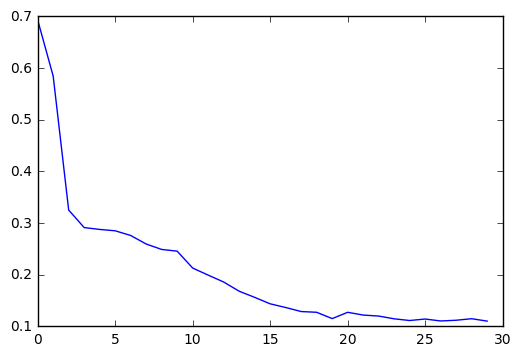

In [125]:
#Plotting losses
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [170]:
##########################################################################################################################
#saving the list of words used for indexing/tokenizing
#rerun of programs will give different order/sets of  unique words and different weights
#while evaluating the saved weights it is necessary to use correspondin set of saved uniq_words as look up
new_file = 'C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\uniq_saved_new.txt'
with open(new_file, 'w') as f:
    for item in uniq_words:
        f.write("%s\n" % item)
#####################################################################################################################

In [174]:
############################################################################################################
#reading the file
read_file = "C:\\Users\\Mnsh\\Documents\\data\\pytorch\word2vec\\SGNS\\uniq_saved_new.txt"
f = open(read_file, "r")
print(f.read())
#############################################################################################################

russian
nations
national
premises
stage
first
acknowledgments
challenges
responsible
enemies
time
islamic
postwar
successors
state
digital
asian
forswearing
thirty
interpretations
do
issue
cold
congress
countries
fair
is
made
cataclysm
most
outside
order
replied
ronald
tradition
pride
minimal
myself
challenge
condition
an
era
defense
ottoman
frequent
factor
great
revolutionary
strategies
rights
western
embracing
their
twenty
presidency
adopting
woodrow
democratic
saudi
pluralistic
human
disorder
this
president
aimed
where
version
presidents
understanding
arabia
city
nuclear
definition
partnership
technology
tide
some
instances
introduction
wars
like
cooperative
kansas
reiler
philosophical
reality
world
european
iranian
concepts
speech
fact
all
or
called
participatory
acting
age
rules
between
them
ambivalent
play
syrian
totally
decline
narrative
mankind
wilson
approaches
different
china
wanted
sovereignty
defeated
multiplicity
then
preservation
century
kissinger
breakdown
both
richard
p

In [ ]:
f.close()

In [158]:
#####################################################################################################
#Alternative way of saving and reading the file using json
import json
#a = [1,2,3,4,5]
d = uniq_words
with open('C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\weights_and_words\\uniq_saved10.txt', 'w') as f:
    f.write(json.dumps(d))

#Now read the file back into a Python list object
with open('C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\weights_and_words\\uniq_saved10.txt', 'r') as f:
    c = json.loads(f.read())
####################################################################################################

In [176]:
c[:5]

['russian', 'nations', 'national', 'premises', 'stage']

In [78]:
#using new networks
#state_dict can be used but weights have to be seperated before transferring

embed_size = 30
fc1 = nn.Linear(len(uniq_words), embed_size, bias = False)
pretrained_weights = torch.load('C:\\Users\\Mnsh\\Documents\\data\\pytorch\\word2vec\\SGNS\\weights_and_words\\fc_midl_wt.pth')
fc11.weight = pretrained_weights

In [180]:
pretrained_weights

Parameter containing:
tensor([[-0.5225, -0.2186, -0.6126,  ..., -0.5997,  0.3447, -1.5748],
        [ 1.3043, -0.0870, -0.4282,  ..., -0.0965,  0.0154,  1.0580],
        [ 0.3189,  0.0833, -0.0369,  ...,  0.2913,  0.2884,  0.7364],
        ...,
        [ 0.0804,  1.0413,  1.1097,  ...,  0.4449,  0.7431,  1.1347],
        [ 0.1467, -0.3945,  0.1304,  ..., -1.5804, -0.6592, -0.1812],
        [ 1.4072,  0.5528,  0.1567,  ...,  0.6486,  1.7909, -0.0341]],
       requires_grad=True)

In [184]:
find_dist_new(fc1, uniq_words, 'henry', 5)

tensor([1.0000, 0.9630, 0.9551, 0.9418, 0.9222])


['henry', 'history', 'kissinger', 'character', 'reflections']